The dataset is the well-known Speech Accent Archive and can be found here: https://accent.gmu.edu/. It is comprised of approximately 2200 recordings of native and non-native English speakers,  each reading the same passage in English. The passage is formulated in a way that captures the majority of the language's diction range. The goal is to classify the native language of the speaker through their accent.  
In order to simplify the problem the classes are narrowed down to just two, creating a binary classification task. Native English speakers from the USA are the first class and comprise the majority of the dataset with 371 instances. Two classes, portuegese and spanish, are combined together to formulate a class, namely iberian-romance, of 210 instances. This choice of binning not only populates a second class, covers a large geographical area for our application too.

In [2]:
##import the necessary libraries
import numpy as np
import librosa
import librosa.display
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import f_classif, SelectFpr
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support, f1_score
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import Matern
import matplotlib.pyplot as plt
import warnings
from yellowbrick.classifier import ROCAUC, ClassificationReport

First we need to load the data. Each audio file is of different length and of the same sampling rate(44.1Kh). We will follow a few audio preprocessing steps before we continue with the feature extraction. For each file the preprocessing steps are as follows:
  1.Load the raw audio. Librosa will load the mp3 file as a (1,m) numpy array, where m = (sampling rate)x(time in seconds). Librosa will also give a warning when attempting to load an mp3 file so we choose to ignore that.
  2.Remove the silent parts of the audio. This is done by a simple algorithm, borrowed from here:https://medium.com/behavioral-signals-ai/basic-audio-handling-d4cc9c70d64d, that separates the audio to short segments and drops those with a low energy. This is done for two reasons: a) it reduces dimensionality, b) since every speaker reads the same passage, removing silence should help to some degree to match the time with the spoken word.
  3.Resampling from 44.1Kh to 11.25Kh. This technique also helps to reduce dimensionality while allowing for some changes to take place between each sampling.
  4.Fixing length to 20 seconds. This is a necessary step in order to load all audios to a single array with 371 + 210 = 581 rows and 11250x20 = 225000 columns.

In [4]:
warnings.filterwarnings("ignore")
classes = "usa iberian-romance".split()  
path = r'C:\Users\user\Music\recordings\recordings'
sr = 11250       
  
def load_audios():
    data = []
    label_index = 0
    y = []
    for c in classes:
        path_of_c = f'{path}\\{c}'
        audiofiles = librosa.util.find_files(path_of_c)
        for audiofile in audiofiles:
            audio, sr = librosa.core.load(audiofile)
            audio = remove_silence(audio, sr)
            new_sr = 11250
            audio = librosa.resample(audio, sr, new_sr)
            new_length = 20*new_sr
            audio = librosa.util.fix_length(audio, new_length)
            y.append(label_index)
            data.append(audio)
        label_index += 1
    data_final = np.array(data)
    y = np.array(y)
    return data_final, y

def remove_silence(audio, sr):
    audio = librosa.util.normalize(audio)
    audio_length = len(audio)
    segment = int(0.5*sr)
    segments = np.array([audio[x:x + segment] for x in 
                         np.arange(0, audio_length, segment)])
    energies = [(s**2).sum()/len(s) for s in segments]
    thres = 0.6*np.median(energies)
    keepers = (np.where(energies > thres)[0])
    segments = segments[keepers]
    audio = np.concatenate(segments)
    return audio

X_raw, y = load_audios()
#check shape of X, nan values, and zero rows
print(X_raw.shape)
print(True in np.isnan(X_raw))
print(np.where(~X_raw.any(axis = 1))[0] is True)

(581, 225000)
False
False


Let's load a couple of examples, one for each class, for some visualizing. 

In [34]:
#two audio examples, one for each class
audio_example = X_raw[0]
audio_example2 = X_raw[-1]

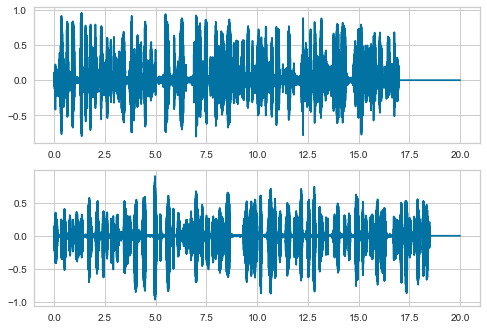

In [35]:
time1 = np.arange(0, 20, 20/len(audio_example))
time2 = np.arange(0, 20, 20/len(audio_example2))
plt.figure()
plt.subplot(2, 1, 1)
plt.plot(time1, audio_example)
plt.subplot(2, 1, 2)
plt.plot(time2, audio_example2)

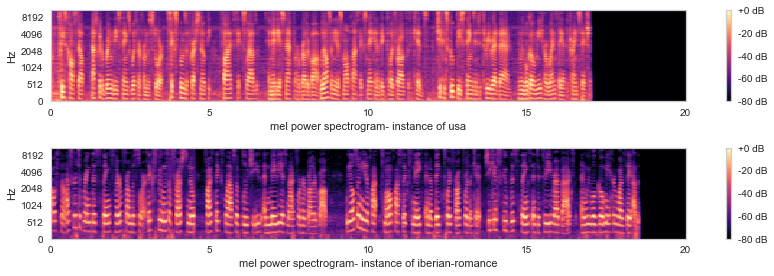

In [58]:
Spec = librosa.feature.melspectrogram(audio_example, sr = sr, n_mels = 128)
log_Spec = librosa.power_to_db(Spec, ref = np.max)
Spec2 = librosa.feature.melspectrogram(audio_example2, sr = sr, n_mels = 128)
log_Spec2 = librosa.power_to_db(Spec2, ref = np.max)


plt.figure(figsize=(12,4))
plt.subplot(2, 1, 1)
librosa.display.specshow(log_Spec, sr = 11250, x_axis = 'time', y_axis = 'mel')
plt.xlabel('mel power spectrogram- instance of usa')
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()

plt.subplot(2, 1, 2)
librosa.display.specshow(log_Spec2, sr = 11250, x_axis = 'time', y_axis = 'mel')
plt.xlabel('mel power spectrogram- instance of iberian-romance')
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()

Next we will extract some features. Extracting Mel-frequency cepstrum coefficients and their derivatives is a common practice in speech classification tasks. 

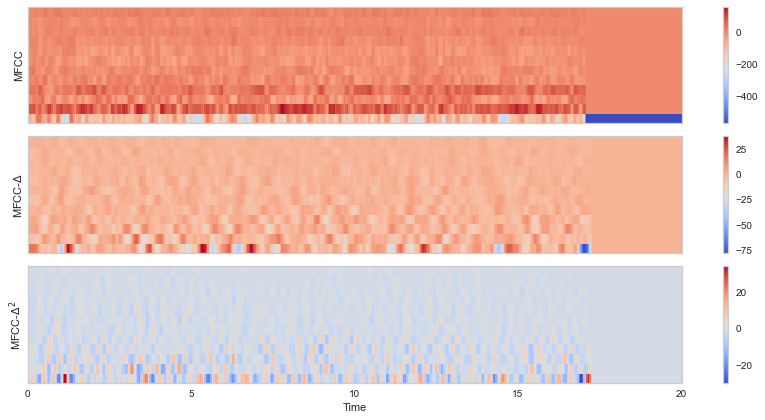

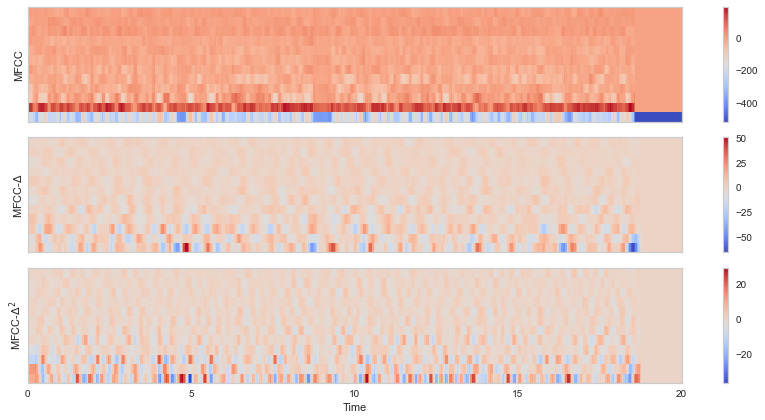

In [36]:
for audio in (audio_example, audio_example2):
    mfccs = librosa.feature.mfcc(y = audio, sr = sr, n_mfcc = 12)
    delta_mfcc  = librosa.feature.delta(mfccs)
    delta2_mfcc = librosa.feature.delta(mfccs, order  = 2)

    plt.figure(figsize=(12, 6))
    plt.subplot(3,1,1)
    librosa.display.specshow(mfccs)
    plt.ylabel('MFCC')
    plt.colorbar()
    plt.subplot(3,1,2)
    librosa.display.specshow(delta_mfcc)
    plt.ylabel('MFCC-$\Delta$')
    plt.colorbar()
    plt.subplot(3,1,3)
    librosa.display.specshow(delta2_mfcc, sr = sr, x_axis = 'time')
    plt.ylabel('MFCC-$\Delta^2$')
    plt.colorbar()
    plt.tight_layout()

In order to take advantage of the fact that all speakers read a common passage, I decided to create features by calculating the mean and the variance of the mel-spectrum coefficients along the numpy axis 0. That is, for every sample taken we keep the mean and the variance of the 13 extracted coefficients. Through trial end error, I also concluded to keep only the means of deltas calculated, this time in numpy axis 1. This decision comes mainly from the fact that mfccs and deltas were usually highly correlated(VIF over 10).
This process yields approximately 2x(225000/256) + 13 =  1770 features

In [13]:
def get_features(audio, sr):
    features = []
    mfccs = librosa.feature.mfcc(audio, sr, n_fft = 2048, hop_length = 256, n_mfcc = 13)
    deltas = librosa.feature.delta(mfccs)
    features.extend(np.mean(mfccs, axis = 0))
    features.extend(np.var(mfccs, axis = 0))
    features.extend(np.mean(deltas, axis = 1))
    return features

def data(X_raw):
    data = []
    for i in range(X_raw.shape[0]):
        x = X_raw[i]
        f = get_features(x, sr)
        data.append(f)
    data = np.array(data)
    return data

X = data(X_raw)
print(X.shape)

Now that we got our features we need to proceed to some standard data preprocessing steps:
  1.Split data to train and test data.
  2.Scale data. A really important techinque before moving on to training any model.
  3.Detect and drop outliers. By outliers here we do not mean outliers in a class, like a really fluent but non-native English speaker, but instead we mean audio outliers, like poor recordings, or extremely unskillful speakers. In this context, Isolation Forest is a suitable solution since it does not take labels into account.
  4.Selecting features found important by a ANOVA test on 0.1 importance level. This step will mainly save as some computation time instead of preventing overfitting, as we will use a few of the most expensive but overfit resistant algorithms. 

In [7]:
##split data to train and test with 4:1 ratio
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.2,
                                                    random_state = 4)
##scale data to (-1, 1) interval
scaler = StandardScaler(copy = False)
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

##drop 10% of data as outliers
iso = IsolationForest(max_features = 22, contamination = 0.1)
yhat = iso.fit_predict(X_train)
mask = yhat != -1
X_train, y_train = X_train[mask, :], y_train[mask]

##ANOVA tests
Selector = SelectFpr(f_classif, alpha = 0.1)
X_train = Selector.fit_transform(X_train, y_train)
X_test = Selector.transform(X_test)

##check new shape, dropped over 1000 features
print(X_train.shape)

(417, 716)


A scatterplot on the first 3 principal components is enough to ensure us that we will achieve some separatability. It looks like that we do have two clusters but quite mixed.

[0.46110985 0.1603239  0.06412398]


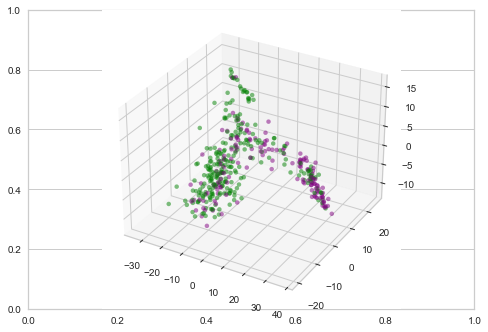

In [8]:
pca = PCA(n_components = 3)
axes = pca.fit_transform(X_train)
print(pca.explained_variance_ratio_)
colors = {0: "green", 1: 'purple'}
fig, ax = plt.subplots()
ax = fig.add_subplot(111, projection = '3d')
for ix, label in enumerate(y_train):
    ax.scatter(axes[ix, 0], axes[ix, 1],
               axes[ix, 2], c = colors[label] , edgecolor = '', alpha = 0.5) 
plt.show()

Now it is time to train some models on our problem. The classifiers used are a Random Forest classifier, a Support Vector Machine and a Gaussian Process. Each classifier is tuned in a GridSearch like cross validation manner using stratified 10Fold.

In [39]:
def RandomForest(X, y):
    accuracy_scores = []
    best_accuracy = 0
    for n in range(5, 200, 25):
        for max_depth in range(1, 5):
            ranfor = RandomForestClassifier(n_estimators = n, max_depth = max_depth,
                                            random_state = 3, max_features = 'log2')
            skf = StratifiedKFold(10)
            for tr, te in skf.split(X, y):
                X_tr, X_te, y_tr, y_te = X[tr], X[te], y[tr], y[te]
                ranfor.fit(X_tr, y_tr)
                y_pr = ranfor.predict(X_te)
                accuracy = f1_score(y_te, y_pr)
                accuracy_scores.append(accuracy)
                if accuracy > best_accuracy:
                    best_accuracy = accuracy
                    ranfor_final = ranfor 
    return ranfor_final, best_accuracy, accuracy_scores
    
random_forest, random_forest_accuracy, scores = RandomForest(X_train, y_train)
print('Random Forest validation accuracy {}%, and variance {}'.format(random_forest_accuracy*100, np.var(scores)))
ranfor_pred = random_forest.predict(X_test)
print('Random Forest test accuracy: {}%'.format(accuracy_score(y_test, ranfor_pred)*100))
print(confusion_matrix(y_test, ranfor_pred))
print(precision_recall_fscore_support(y_test, ranfor_pred, zero_division = 0, average = 'macro'))

Random Forest validation accuracy 69.23076923076923%, and variance 0.008861894200148508
Random Forest test accuracy: 77.77777777777779%
[[66 11]
 [15 25]]
(0.7546296296296295, 0.7410714285714286, 0.7466688874083944, None)


In [38]:
def SVM(X, y):
    f1_scores = []
    best_f1 = 0
    svm_final = None
    for C in (0.02, 0.05, 0.1, 0.5, 1, 2, 5, 10):
        kf = StratifiedKFold(10)
        svm = SVC(C = C, kernel = 'rbf', gamma = 'scale', probability = True, random_state = 3)
        for tr, te in kf.split(X, y):                
            X_tr, X_te, y_tr, y_te = X[tr], X[te], y[tr], y[te]
            svm.fit(X_tr, y_tr)
            y_pr = svm.predict(X_te)
            f1 = f1_score(y_te, y_pr) 
            f1_scores.append(f1)
            if f1 > best_f1:
                best_f1 = f1
                svm_final = svm 
    return svm_final, best_f1, f1_scores

svm, svm_valid_f1, scores = SVM(X_train, y_train)
print('SVM validation f1 score: {}%, and variance: {}'.format(svm_valid_f1*100, np.var(scores)))
svm_pred = svm.predict(X_test)
print('SVM  test accuracy: {}%'.format(accuracy_score(y_test, svm_pred)*100))
print(confusion_matrix(y_test, svm_pred))
print(precision_recall_fscore_support(y_test, svm_pred, zero_division = 0, average = 'macro'))

SVM validation f1 score: 72.00000000000001%, and variance: 0.05652005181413404
SVM  test accuracy: 78.63247863247864%
[[66 11]
 [14 26]]
(0.7638513513513514, 0.7535714285714286, 0.7580445032674332, None)


In [12]:
def GP(X, y):
    f1_scores = []
    best_f1 = 0
    best_gp = None
    for i in range(1, 3):
        skf = StratifiedKFold(10)
        gp = GaussianProcessClassifier(kernel = Matern(i + 0.5), 
                                       n_restarts_optimizer = 3,
                                       max_iter_predict = 400,
                                       n_jobs = -1,
                                       random_state = 3)
        for tr, te in skf.split(X, y):
            X_tr, X_te, y_tr, y_te = X[tr], X[te], y[tr], y[te]
            gp.fit(X_tr, y_tr)               
            y_pr = gp.predict(X_te)
            f1 = f1_score(y_te, y_pr)
            f1_scores.append(f1)
            if f1 > best_f1:
                best_f1 = f1
                best_gp = gp
    return best_gp, best_f1, f1_scores
    
gp, gp_valid_f1, scores = GP(X_train, y_train)
print('GP validation f1 score: {}%, and variance: {}'.format(gp_valid_f1*100, np.var(scores)))
gp_pred = gp.predict(X_test)
print('GP test accuracy: {}%'.format(accuracy_score(y_test, gp_pred)*100))
print(confusion_matrix(y_test, gp_pred))
print(precision_recall_fscore_support(y_test, gp_pred, average = 'macro', zero_division = 0))

GP validation f1 score: 69.23076923076923%, and variance: 0.00560819098404609
GP test accuracy: 82.05128205128204%
[[68  9]
 [12 28]]
(0.8033783783783783, 0.7915584415584416, 0.7967573827446439, None)


The Gaussian Process classifier seems to be a little more effective than the other two classifiers. All classifiers though have a hard time when classifying the iberian-romance class as shown by the respective confusion matrices. A simple answer is the fact that the minority class is the one most commonly misclassified. The same conclusion can be drawn by examining the predicting scores of the classifiers by class. Below is shown a concise evaluation table for tha Gaussian Process classifier.

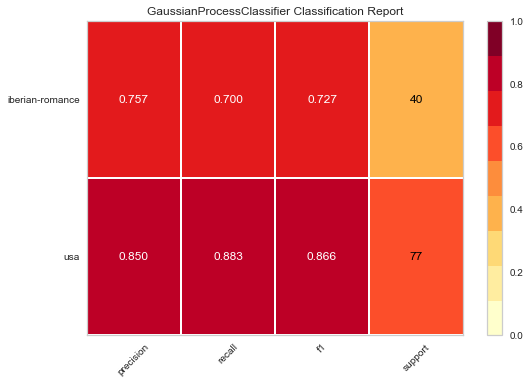

<AxesSubplot:title={'center':'GaussianProcessClassifier Classification Report'}>

In [41]:
report = ClassificationReport(gp, classes = ['usa', 'iberian-romance'], support = True)
report.fit(X_train, y_train)
report.score(X_test, y_test)
report.show()

Another explanation for the difficulty the models have in classifying the iberian-romance class is that English is a wide spread language, meaning that many speakers are fluent in more than one languages. Nevertheless, all metrics, area under curve for each class included, are quite satisfying.

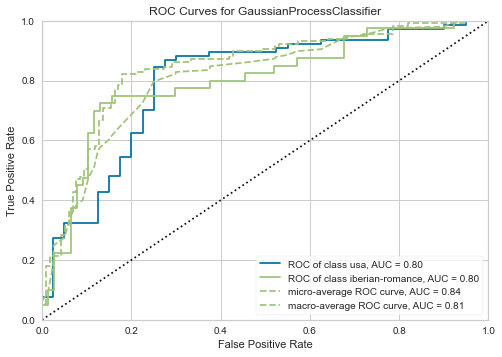

<AxesSubplot:title={'center':'ROC Curves for GaussianProcessClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [42]:
rocauc_ = ROCAUC(gp, classes = ['usa', 'iberian-romance'])
rocauc_.fit(X_train, y_train)
rocauc_.score(X_test, y_test)
rocauc_.show()

As for to which metric is the most appropriate, the answer is application specific. By moving the separation threshold we can maximize the desired predicting score. Νumeric exploration for the maximization of precision, recall and f1 scores is performed below.

In [53]:
top_precision, top_recall , top_f1= 0, 0, 0
precision_threshold, recall_threshold, f1_threshold = 0, 0, 0
for threshold in np.arange(0.2, 0.8, 0.005):
    pred_prob =gp.predict_proba(X_test)
    pred = (pred_prob[:, 1] >= threshold).astype('int')
    scores = precision_recall_fscore_support(y_test, pred, zero_division = 0, average = 'macro')
    if scores[2] > top_f1:
        top_f1 = scores[2]
        f1_threshold = threshold
    if scores[0] > top_precision:
        top_precision = scores[0]
        precision_threshold = threshold
    if scores[1] > top_recall:
        top_recall = scores[1]
        recall_threshold = threshold
print('Best precision score achieved {}% with a separation threshold of {}.'.format(top_precision*100, precision_threshold))
print('Best recall score achieved {}% with a separation threshold of {}.'.format(top_recall*100, recall_threshold))
print('Best f1 score achieved {}% with a separation threshold of {}.'.format(top_f1*100, f1_threshold))

Best precision score achieved 83.47826086956522% with a separation threshold of 0.6700000000000004.
Best recall score achieved 79.7564935064935% with a separation threshold of 0.45000000000000023.
Best f1 score achieved 79.93466721110659% with a separation threshold of 0.45000000000000023.


In conlusion, the dataset is well annotated and the vast majority of the recordings follow great standards. Any complexity in the problem comes mainly from fluent in English or very unfamiliar with the language speakers. With that saying, there are plenty of skillful classifiers that could be tried and tested like Boosting algorithms, HMMs, NNs but most likely they will achieve similar results as their counterparts tested above. In order to squeeze a bit more efficiency, it would be meaningfull to gather more data and/or further experiment with feature extraction ideas. The last is more obvious when using CNNs.